<a href="https://colab.research.google.com/github/joshbrx/biomath_model/blob/main/Stellate_N_cancer_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRN model for stellate cells in pancreas.

Para modelar correctamente la red de regulación genética, renormbraremos las variables del sistema para poder simplificar el proceso

| $TNF_a$ | $TGFb_1$ | $RAS$ | $P53$ | $PIP3$ | $ERK$ | Apoptosis | Proliferation |
|:-------:|:--------:|:-----:|:-----:|:------:|:-----:|:-----------:|:---------------:|
|  $X_1$  |   $X_2$  | $Y_1$ | $Y_2$ |  $Y_3$ | $Y_4$ |    $Z_1$    |      $Z_2$      |

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def supr(e, n, s):
    return e/(1 + s**n)

In [21]:
def dS(S, i, y1_tau):
    y1, y2, y3, y4, c2, c3, c4, c5, z1, z2, z3, z4, Ry1, Ry2, Ry3, Ry4, Rc2a, Rc2b, Rc2, Rc3, Rc4, Rc5, Rz1, Rz2, Rz3, Rz4, c2a, c2b = S
    # --------------------------------------------------------
    # dRy1 = e[0]*(supr(1, n[0], X1[i]) + supr(1, n[0], y1) + supr(1, n[0], y3) + supr(1, n[0], y4) + supr(1, n[0], c3)) - Ry1
    dRy1 = e[0]*(supr(1, n[0], X1[i]) + supr(1, n[0], y1_tau) + supr(1, n[0], y3) + supr(1, n[0], y4)) - Ry1;           # delay
    dy1  = supr(1, n[1], Ry1) - y1;

    dRy4 = e[1]*(supr(1, n[0], X2[i]) + supr(1, n[0], y1)) - Ry4;
    dy4  = supr(1, n[1], Ry4) - y4;

    dRy3 = e[2]*(supr(1, n[0], y4) + supr(1, -n[0], y2)) - Ry3         
    dy3  = supr(1, n[1], Ry3) - y3;

    dRy2 = e[3]*(supr(1, n[0], 2*y1) + supr(1, -n[0], 2*y2) + supr(1, -n[0], 2*y3)) - Ry2
    dy2  = supr(1, n[1], Ry2) - y2;
    # --------------------------------------------------------
    # dRz1 = dRy2; dz1  = dy2;
    dRz2 = e[4]*(supr(1, -n[0], y2) + supr(1, n[0], y4)) - Rz2
    dz2  = supr(1, n[1], Rz2) - z2;
    # --------------------------------------------------------
    dRc2a = e[5]*(supr(2, -n[0], c2) + supr(2, -n[0], c3)) - Rc2a
    dc2a  = supr(1, n[1], Rc2a) - c2a;
    dRc2b = e[6]*(supr(2, +n[0], c2) + supr(2, -n[0], c3)) - Rc2b
    dc2b  = supr(1, n[1], Rc2b) - c2b;
    dRc2 = e[7]*(supr(2, +n[0], c2) + supr(2, -n[0], c3)) - Rc2
    dc2  = supr(1, n[1], Rc2) - c2;

    dRc3 = e[8]*(supr(1, n[0], y1_tau) + supr(1, -n[0], c2)) - Rc3
    dc3  = supr(1, n[1], Rc3) - c3;

    dRc4 = e[9]*(supr(1, n[0], y1_tau) + supr(1, n[0], c3) + supr(2, -n[0], c2)) - Rc4
    dc4  = supr(1, n[1], Rc4) - c4;

    dRc5 = e[10]*(supr(1, n[0], X2[i]) + supr(1, n[0], c2)) - Rc5
    dc5  = supr(1, n[1], Rc5) - c5;
    # --------------------------------------------------------
    dRz3 = e[11]*(supr(2, -n[0], c3) + supr(1, n[0], c2) + supr(1, -n[0], c4)) - Rz3
    dz3  = supr(1, n[1], Rz3) - z3;

    dRz4 = e[12]*(supr(1, n[0], y1) + supr(1, n[0], c3) + supr(1, -n[0], c5)) - Rz4
    dz4  = supr(1, n[1], Rz4) - z4;
    # --------------------------------------------------------
    dS = [dy1, dy2, dy3, dy4, dc2, dc3, dc4, dc5, dy2, dz2, dz3, dz4, dRy1, dRy2, dRy3, dRy4, dRc2a, dRc2b, dRc2, dRc3, dRc4, dRc5, dRy2, dRz2, dRz3, dRz4, dc2a, dc2b]
    return np.array(dS)

In [26]:
def RK_solver(S0, t, k):
    dims = len(S0)
    K = np.empty([4, dims])
    S = np.zeros([len(t)+1, dims])
    
    for d in range(dims):   
        S[0, d] = S0[d]

    dt = t[1] - t[0]; 
    for i in range(len(t)):
        y1_tau = S[i-k, 0]
        K[0] = dt * dS(S[i]         , i, y1_tau) 
        K[1] = dt * dS(S[i] + K[0]/2, i, y1_tau)
        K[2] = dt * dS(S[i] + K[1]/2, i, y1_tau)
        K[3] = dt * dS(S[i] + K[2]  , i, y1_tau)
        for d in range(dims):
            S[i+1, d] = S[i, d] + (K[0,d]+2*K[1,d]+2*K[2,d]+K[3,d])/6
    return S

In [116]:
# parámetros
n = [-4, -20] 
# e = [1/0.25, 1/0.25, 0.85, 0.43, 1/1.25, 1/2.25, 1/0.25, 1/1.25, 1/4.25, 1/2.75, 1/1.75]
e = [2.5, 2.5, 0.45, 0.45, 1/1.25, 1/1.4, 1, 1/0.2, 2.5, 1/1.25, 1/4.25, 1/2.75, 1/1.75]
start=0; step=0.1; num=2000
t = np.arange(0,num)*step+start

<ipython-input-3-c9dcc9093113>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return e/(1 + s**n)
<ipython-input-3-c9dcc9093113>:2: RuntimeWarning: overflow encountered in double_scalars
  return e/(1 + s**n)


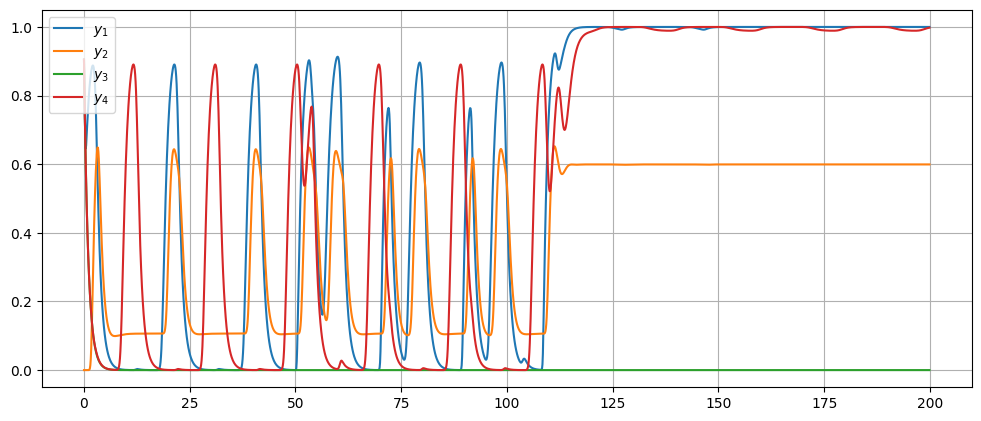

In [117]:
S0 = np.concatenate([np.array([1, 0, 1, 1]), np.zeros(8), np.zeros(16)])   # R, Y, C, Z
A = np.array([1,1,1,1]);
omega = 1/6.157; X1, X2 = np.cos(t*omega)**2, np.sin(t*omega)**2            # omega_max = 7.715
# X1, X2 = np.ones(num), np.ones(num)       
labels = ["$y_1$","$y_2$","$y_3$","$y_4$","$s_2$","$s_3$","$s_4$","$s_5$","$z_1$","$z_2$","$z_3$","$z_4$"]

Pip = RK_solver(S0, t, 500)
plt.figure(figsize=(12,5), dpi=100)
for i in range(4):
    plt.plot(t, Pip[1:,i], label=labels[i])
plt.legend(); plt.grid(); plt.show()

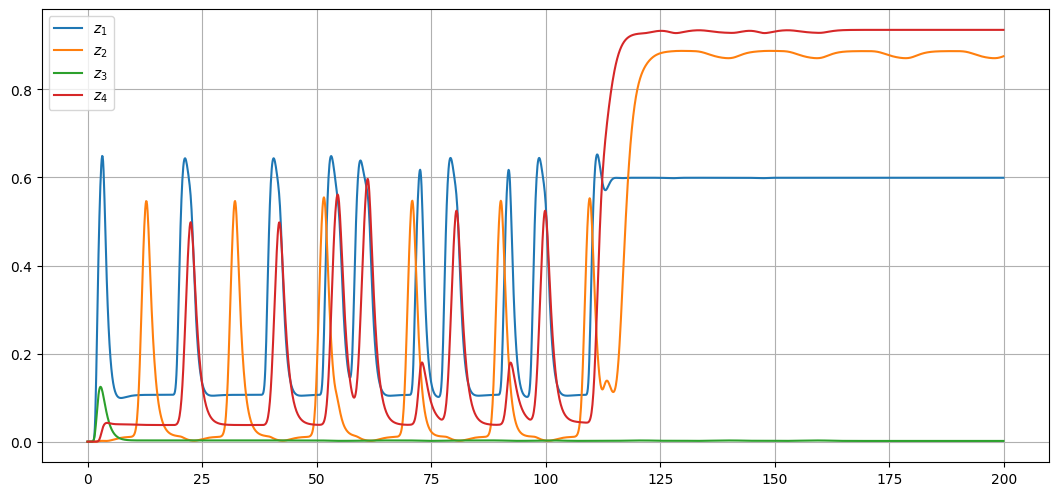

In [120]:
plt.figure(figsize=(13,6), dpi=100)
for i in range(4):
    plt.plot(t, Pip[1:,i+8]*A[i], label=labels[i+8])
# for i in range(len(Pip[0])-8):             plt.plot(Pip[:,i+8], label=labels[i+3])
# plt.plot(X1)
plt.legend(); plt.grid(); plt.show()

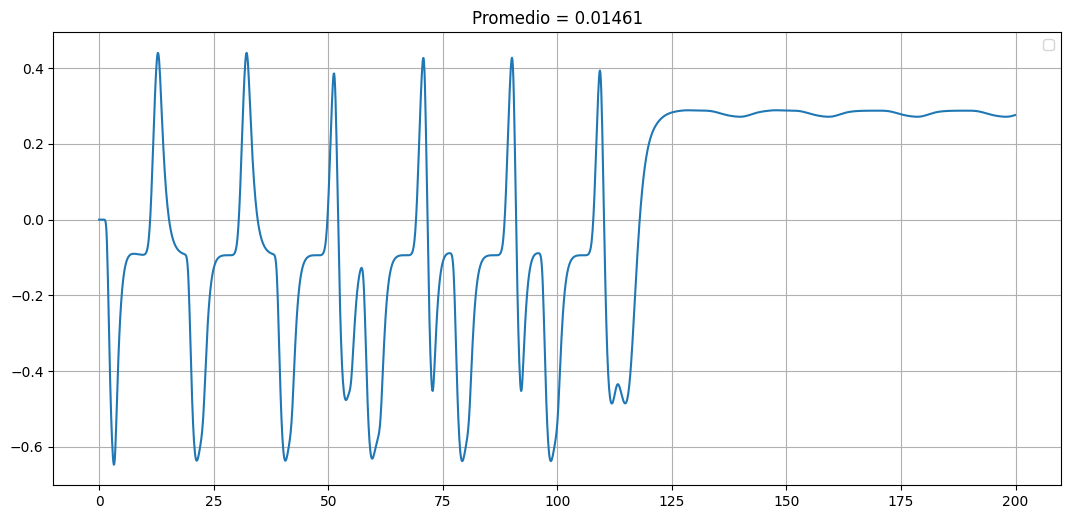

In [121]:
plt.figure(figsize=(13,6), dpi=100)

# plt.plot(-Pip[:,8] + Pip[:,9] - Pip[:,10] + Pip[:,11])
plt.plot(t, -Pip[1:,8] + Pip[1:,9])
plt.legend(); plt.grid(); plt.title(f"Promedio = {round(np.mean(-Pip[:,8] + A[1]*Pip[:,9]), 5)}"); plt.show()

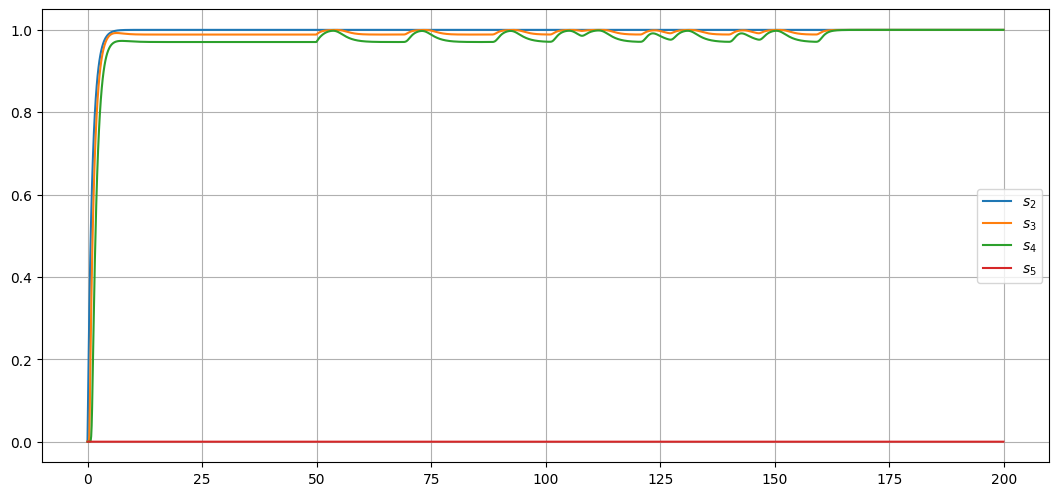

In [122]:
plt.figure(figsize=(13,6), dpi=100)
for i in range(4):
    plt.plot(t, Pip[1:,i+4], label=labels[i+4])
plt.legend(); plt.grid(); plt.show()